In [1]:
import os
import warnings

import matplotlib
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import model
import numpy as np
import torch
from data import colorDict, onehot2rgb, rgb2onehot
from PIL import Image

warnings.filterwarnings(action="ignore")

test


In [2]:
data_root = r"/mnt/d/data/"
weight_file = "./experiment/vgg16_largefov/vgg16_large_fov_best.pt"


use_gpu = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_classes = len(colorDict.keys())

iter_max = 10
bi_w = 7
bi_xy_std = 50
bi_rgb_std = 4
pos_w = 3
pos_xy_std = 3

cpu


### data distribution


In [4]:
# from data import compute_data_counz

# mask_dir = os.path.join(data_root, "Labels")
# count = compute_data_count(mask_dir, colorDict)
# # 单线程 5m10s，12750张图像

In [5]:
count = {
    "background": 180759544,
    "luad1": 100370290,
    "luad2": 112588848,
    "luad3": 41976891,
    "luad4": 12342852,
    "alveolous": 191705575,
}

In [6]:
count_percent = {
    k: int(v / sum(count.values()) * 10000) / 100 for k, v in count.items()
}
count_percent

{'background': 28.25,
 'luad1': 15.68,
 'luad2': 17.59,
 'luad3': 6.56,
 'luad4': 1.92,
 'alveolous': 29.96}

In [7]:
plt.style.use("ggplot")
bars = plt.bar(
    count_percent.keys(),
    count_percent.values(),
    color=np.array(list(colorDict.values())) / 255,
)
plt.bar_label(bars, map(lambda x: f"{x}%", count_percent.values()))
plt.title("Mask Class Distribution")

Text(0.5, 1.0, 'Mask Class Distribution')

### deeplab


In [8]:
# def show_im_mask(image_dir: str, mask_dir: str, predict: np._typing.NDArray) -> None:
#     image = matplotlib.image.imread(image_dir)
#     mask = Image.open(mask_dir)

#     cmap = colors.ListedColormap(np.array(list(colorDict.values()))/255)
#     fig=plt.figure(figsize=(25, 8))
#     fig.patch.set_facecolor('lightgrey')
#     gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05],  wspace=0.1)

#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])
#     ax3 = plt.subplot(gs[2])
#     cax = plt.subplot(gs[3])

#     ax1.imshow(image)
#     mask = ax2.imshow(mask, cmap=cmap)
#     ax3.imshow(predict)

#     cbar = plt.colorbar(mask, cax=cax)
#     cbar.ax.set_yticks([])  # Hide the ticks on the colorbar
#     # Hide the ticks on ax1, ax2, and ax3
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     ax3.set_xticks([])
#     ax3.set_yticks([])

#     tick_locs = (np.arange(len(colorDict)) + 0.5) / len(colorDict)*255

#     # Set the ticks and labels for the colorbar with a specific font size
#     cbar.set_ticks(tick_locs)
#     # Adjust fontsize as needed
#     cbar.ax.set_yticklabels(list(colorDict.keys()), fontsize=22)

#     # Title of each axis in the plot
#     title_size = 26
#     ax1.set_title('Original Image', fontsize=title_size)
#     ax2.set_title('Ground Truth Mask', fontsize=title_size)
#     ax3.set_title('Predicted Mask', fontsize=title_size)
#     plt.show()

In [101]:
from typing import List


def show_im_mask(
    im_paths: List[str], mask_paths: List[str], predicts: List[np._typing.NDArray]
) -> None:
    fig, axes = plt.subplots(len(im_paths), 3, figsize=(17, 6 * len(im_paths)))
    fig.patch.set_facecolor("lightgrey")
    plt.subplots_adjust(wspace=0.01, hspace=0)
    for i in range(len(im_paths)):
        image = Image.open(im_paths[i])
        mask = Image.open(mask_paths[i])
        mappable = None
        cmap = colors.ListedColormap(np.array(list(colorDict.values())) / 255)
        for j, arr in enumerate([image, mask, predicts[i]]):
            ax = axes[i, j]
            if j == 2:
                mappable = ax.imshow(arr, cmap)
            else:
                ax.imshow(arr)
            if i == 0:
                if j == 0:
                    ax.set_title("Original Image", fontsize=26)
                if j == 1:
                    ax.set_title("Ground Truth Mask", fontsize=26)
                if j == 2:
                    ax.set_title("Predicted Mask", fontsize=26)
            ax.set_xticks([])
            ax.set_yticks([])
        cax = axes[i, 2].inset_axes([1.05, 0, 0.03, 1])
        cbar = plt.colorbar(mappable, cax=cax)
        cbar.ax.set_yticks([])  # Hide the ticks on the colorbar
        tick_locs = (np.arange(len(colorDict)) + 0.5) / len(colorDict) * 255
        cbar.set_ticks(tick_locs)
        cbar.ax.set_yticklabels(list(colorDict.keys()), fontsize=22)
    plt.show()

In [102]:
from torch import nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
import albumentations as A
import json
from PIL import Image

deeplab = model.VGG16_LargeFOV(num_classes=num_classes, init_weights=False)
model_state_dict = torch.load(weight_file, map_location=torch.device("cpu"))[
    "model_state_dict"
]
deeplab.load_state_dict(model_state_dict)
deeplab.eval()

plot_root = "/mnt/d/data/plot/"
im_root, mask_root = os.path.join(plot_root, "Images"), os.path.join(
    plot_root, "Labels"
)


def plot_results(im_root, mask_root):
    im_paths, mask_paths = os.listdir(im_root), os.listdir(mask_root)
    im_paths, mask_paths = (
        [os.path.join(im_root, p) for p in im_paths],
        [os.path.join(mask_root, p) for p in mask_paths],
    )
    predict_masks = []
    for im_path in im_paths:
        im = Image.open(im_path)
        with open("config.json", "r") as f:
            config = json.load(f)
            mean, std = config["mean"], config["std"]
        transform = A.Compose(
            [A.Resize(256, 256), A.Normalize(mean=mean, std=std), ToTensorV2(True)]
        )
        transformed_image = transform(image=np.array(im))["image"]

        predict_mask = deeplab(transformed_image)
        predict_mask = F.interpolate(
            predict_mask.unsqueeze(0),
            size=(256, 256),
            mode="bilinear",
            align_corners=False,
        )
        predict_mask = nn.Softmax2d()(predict_mask)
        predict_mask = predict_mask[0]
        predict_mask = torch.argmax(predict_mask, dim=0)
        predict_mask = predict_mask.cpu().numpy()
        predict_masks.append(onehot2rgb(predict_mask, colorDict))

    show_im_mask(im_paths, mask_paths, predict_masks)

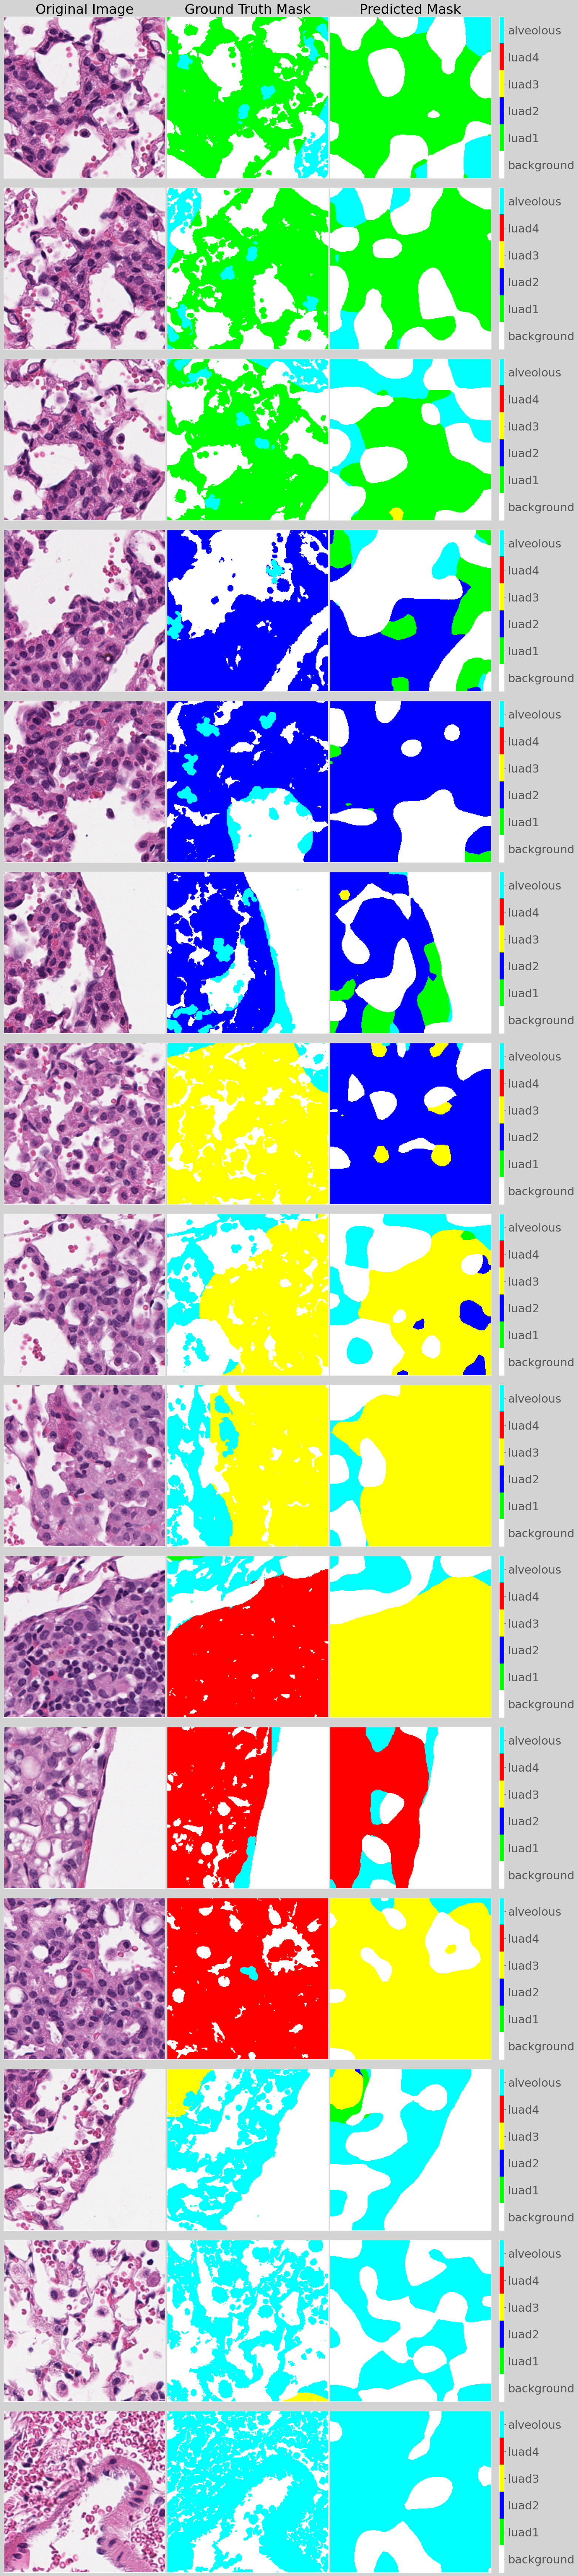

In [103]:
plot_results(im_root, mask_root)

### deeplab+crf


In [ ]:
DeepLab_v1 = model.DeepLab_v1(
    num_classes=num_classes, use_gpu=use_gpu, device=device, weight_file=weight_file
)
predicts = DeepLab_v1.inference(
    image_dir=image_dir,
    iter_max=iter_max,
    bi_w=bi_w,
    bi_xy_std=bi_xy_std,
    bi_rgb_std=bi_rgb_std,
    pos_w=pos_w,
    pos_xy_std=pos_xy_std,
)

predicts = onehot2rgb(predicts, colorDict)

In [50]:
show_im_mask(image_dir, mask_dir, predicts)